In [1]:
from src import *

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- [Emotion item data](#emotion)
    - Reformatting
    - Exploring
- [fMRI data](#fmri)
    - Reformatting
    - Exploring

<a class="anchor" id="emotion"></a>
### Emotion item data

In [4]:
emo_path = "./data/emoFiles/emo/"

We simplify the datasets so to make it easier in the future to load. Be careful that the formats for any of our processed emotion csv would be the following way.

Reformatting

In [5]:
# we find the labels matching the index to know which item we are accessing
df     = pd.read_csv(emo_path + '/W_labels.csv', sep='\t')
labels = list(df.columns) + list(df.iloc[:,0])
labels = {idx:emotion for idx, emotion in enumerate(labels)}

In [6]:
# we keep a dictionary with each film and their respective scores for each item in a double array
record = {'filename': [], 'item': [], 'score': []}
for filename in tqdm(os.listdir(emo_path)):
    if 'labels' in filename: continue
    df           = pd.read_csv(emo_path + '/' + filename, sep='\t')
    double_array = np.concatenate((np.array(df.columns).astype(float)[None],np.array(df)))
    nbt, nbitem  = double_array.shape
    
    for item_idx in range(nbitem):
        record['score'] += list(double_array[:,item_idx])
        record['item'] += ([labels[item_idx]] * nbt)

    record['filename'] += ([filename] * nbt * nbitem)

emo_df = pd.DataFrame.from_dict(record)

# #Uncomment to save the record to csv
# emo_df.to_csv('./data/emotion_compile.csv', index=False)

100%|██████████| 15/15 [00:00<00:00, 108.59it/s]


Exploring

From the following plot we see in each videos whether the item is present

NOTE: need to understand:
- where events are
- which feeling is happening the most often in general we don't have absolute values so timesereis from metrics should be discrete differences as well 
- how long an event is happening for us to be able to catch it in terms of change 

In [80]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

In [88]:
stats1    = emo_df.groupby(['filename', 'item']).std()
tmp = stats1.reset_index()

stats1inv = emo_df.groupby(['item', 'filename']).mean()
stats2inv = emo_df.groupby(['item', 'filename']).std()

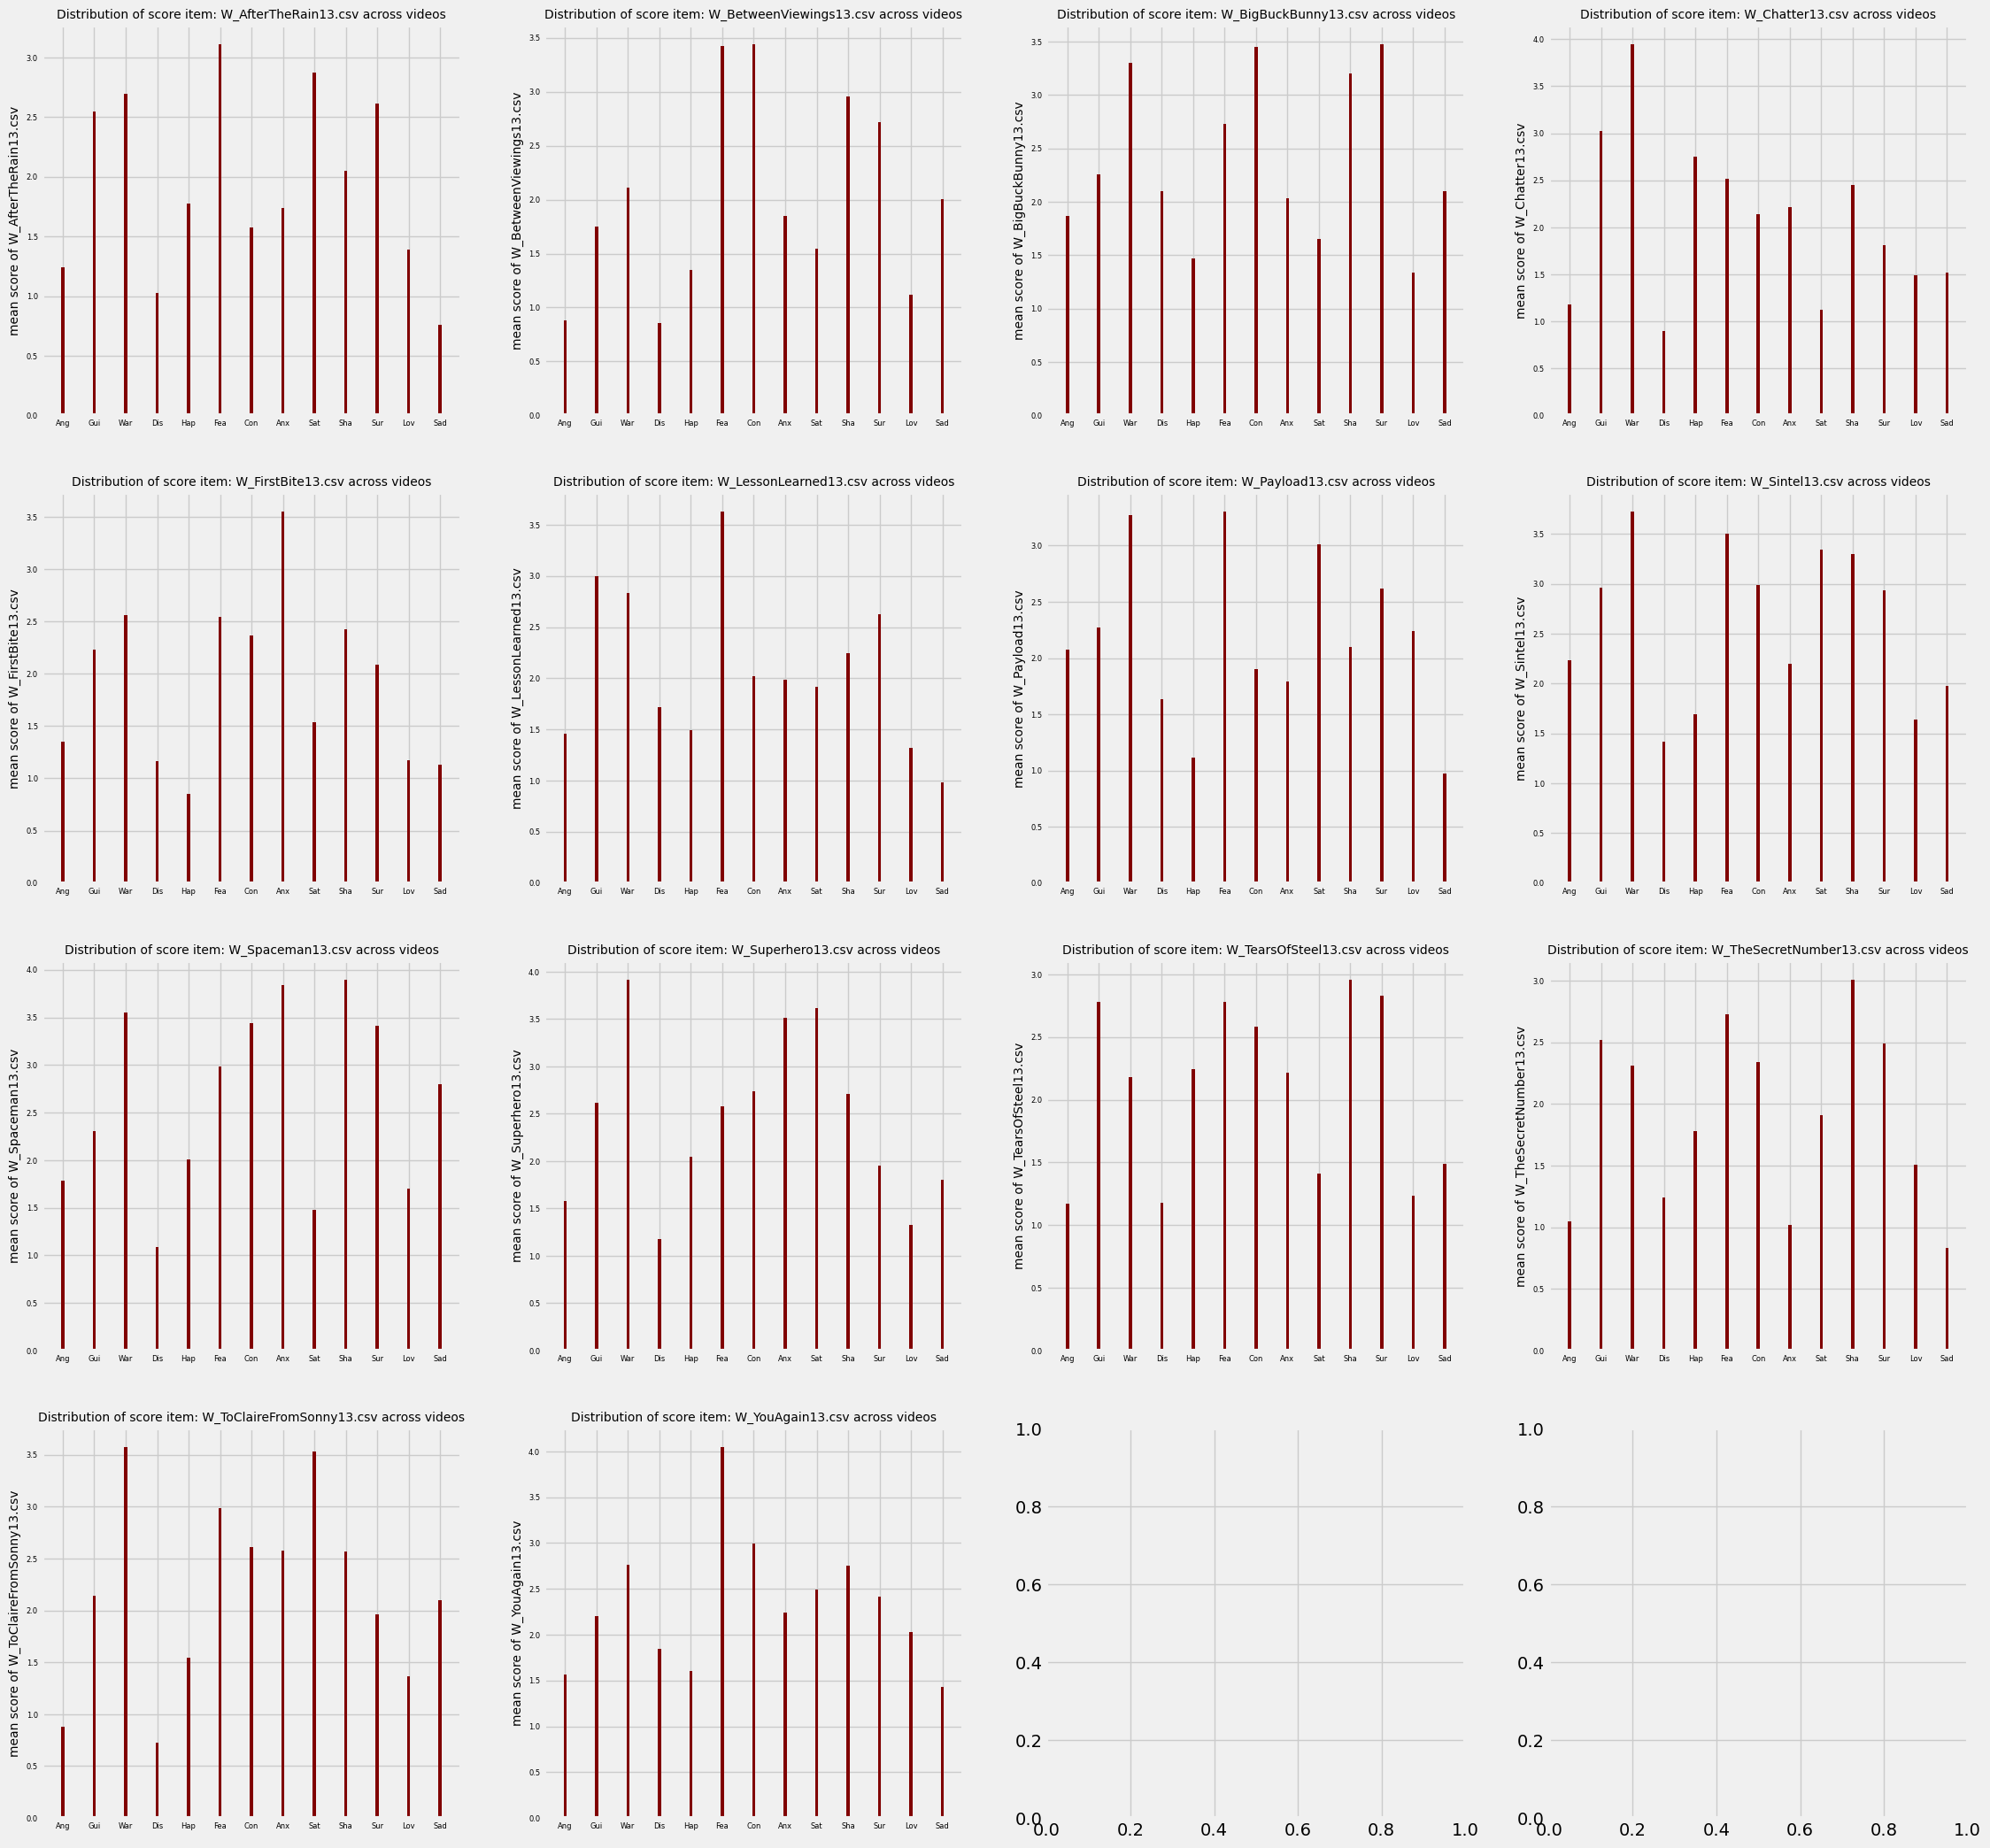

In [104]:
fig, ax = plt.subplots(4,4, figsize=(25,25))

for fidx, emo in enumerate(tmp.filename.unique()):
    row, col = fidx // 4, fidx % 4
    ftmp = tmp[tmp.filename == emo]
    p    = [ftmp.iloc[f].score for f in range(len(ftmp)) if ftmp.iloc[f]['item'] in select]
    
    ax[row, col].bar([s[:3] for s in select], p, capsize=10,
        color ='maroon', width = 0.1)
    ax[row, col].set_title("Distribution of score item: {} across videos".format(emo), size=10)
    ax[row, col].set_ylabel('mean score of {}'.format(emo), size=10)
    ax[row,col].tick_params(labelsize=6)

Text(0, 0.5, 'mean score of Sad')

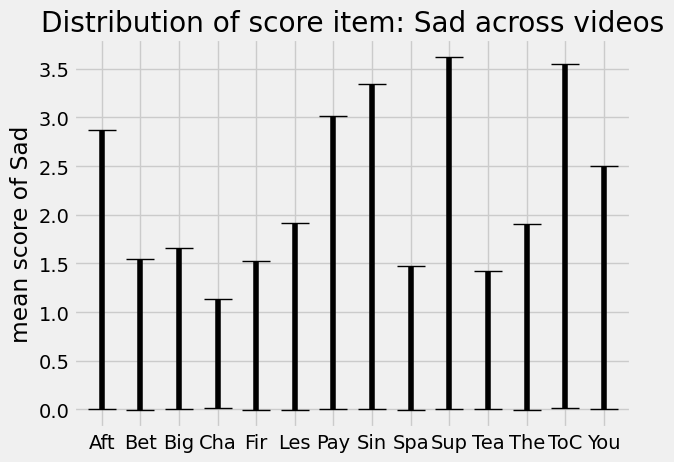

In [57]:
item = 'Sad'
nb_vid = stats1inv.loc[item].shape[0]
fig, ax = plt.subplots()

# create bar plot
movie_labels = list(stats1inv.loc[item].index)
movie_labels = [m[2:5] for m in movie_labels]

means = np.array(stats1inv.loc[item]['score'])
stds  = np.array(stats2inv.loc[item]['score'])
plt.bar(movie_labels, means, 
        yerr= [np.zeros_like(stds), stds], capsize=10,
        color ='maroon', width = 0.1)
plt.title("Distribution of score item: {} across videos".format(item))
plt.ylabel('mean score of {}'.format(item))

Let's as well visualize the timeseries for few items in a movie

In [105]:
emo_df.item.unique()

array(['Support', 'Stop', 'Care', 'Sad', 'Predictable', 'Lips', 'Throat',
       'Move', 'Frown', 'Warm', 'Guilt', 'PleasantSelf', 'Tackle',
       'PleasantOther', 'Controlled', 'Standards', 'Disgust', 'Agent',
       'AtEase', 'Oppose', 'Tears', 'Anxiety', 'IntenseEmotion',
       'Attention', 'Stomach', 'Good', 'Alert', 'Happiness', 'Calm',
       'Anger', 'Eyebrows', 'Repeat', 'Muscle', 'SocialNorms', 'Smile',
       'Surprise', 'Bad', 'Suddenly', 'GoalsOther', 'WarmHeartedness',
       'Love', 'Heartrate', 'Satisfaction', 'Fear', 'Contempt', 'Command',
       'Urgency', 'Shame', 'Strong', 'Undo'], dtype=object)

Text(0.5, 1.0, 'Scores over time for W_Chatter13.csv')

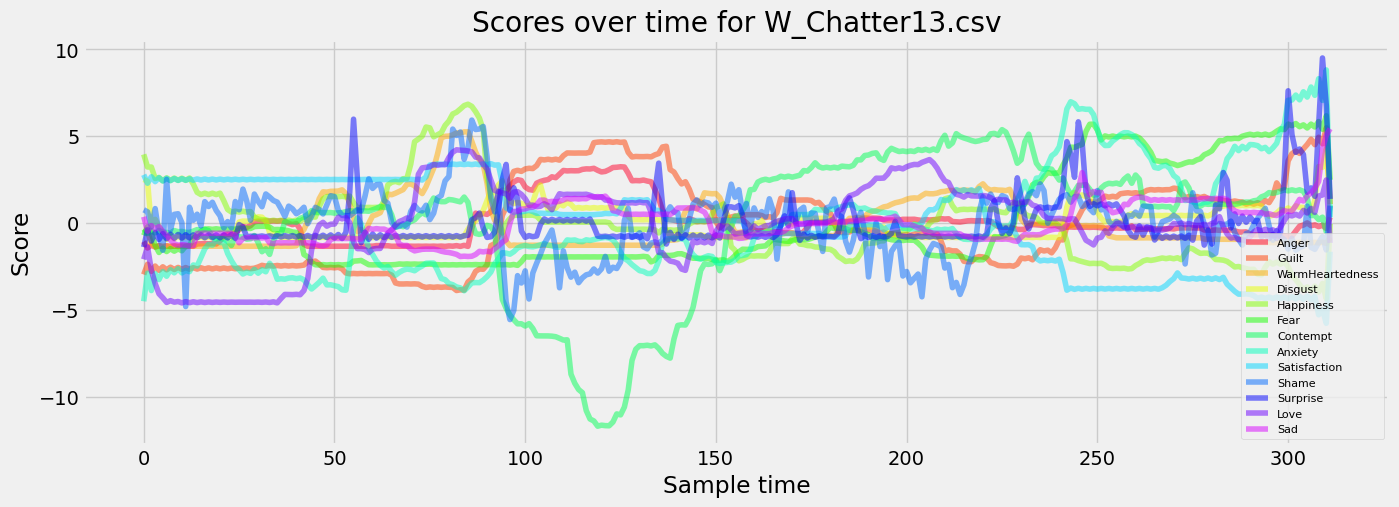

In [114]:
# NOTE: that the temporal coherence was kept when we reformatted the files
moviename = 'W_Chatter13.csv'
emotions  = ['Sad', 'Support', 'Care']

NUM_COLORS = len(select)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for s in select:
        cur_df = emo_df[(emo_df['filename'] == moviename) & 
                (emo_df['item'] == s)]   
        ax.plot(np.arange(len(cur_df)), cur_df['score'], label=s, alpha=0.5)
ax.legend(prop={'size':8})
ax.set_xlabel('Sample time')
ax.set_ylabel('Score')
ax.set_title('Scores over time for {}'.format(moviename))

<a class="anchor" id="fmri"></a>
### fMRI data

In [8]:
mri_path = "./data/fMRIFiles/TCFiles/"

Reformatting

In [9]:
labels = pd.read_csv('./data/labels/7N_networks_centroids.csv')

In [22]:
files = os.listdir(mri_path)
names = ['AfterTheRain.csv']
names = [n.strip('.csv') for n in names]

Cortical Only

In [25]:
for idx in tqdm(range(len(names))):
    files_specific = [f for f in files if names[idx] in f]

    # we keep a dictionary with each film and their respective scores for each item in a double array
    record = {'filename': [], 'vindex': [],'full_region': [], 
                'partial_region': [],'score': [], 'movie_name':[], 'parcel': []
                ,'id': [], 'session': []}
    for filename in tqdm(files_specific):
        _, parcel, _id, session, moviename = filename.split('_')
        moviename    = moviename.strip('.csv')
        df           = pd.read_csv(mri_path + '/' + filename)
        double_array = np.concatenate((np.array(df.columns).astype(float)[None],np.array(df)))
        nbt, nbvoxel = double_array.shape
        
        for voxel_idx in range(nbvoxel):
            record['score'] += list(double_array[:,voxel_idx])
            record['vindex'] += [voxel_idx] * nbt
            
            region_name  = labels[labels['ROI Label'] == voxel_idx + 1]['ROI Name'].item()
            # partial_name = '_'.join(region_name.split('_')[1:-1])
            partial_name = region_name.split('_')[2]
            record['full_region']    += ([region_name] * nbt)
            record['partial_region'] += ([partial_name] * nbt)


        record['filename']   += ([filename] * nbt * nbvoxel)
        record['movie_name'] += ([moviename] * nbt * nbvoxel)
        record['parcel']     += ([parcel] * nbt * nbvoxel)
        record['id']         += ([_id] * nbt * nbvoxel)
        record['session']    += ([session] * nbt * nbvoxel)

    mri_df = pd.DataFrame.from_dict(record)

    # #Uncomment to save the record to csv
    mri_df.to_csv('./data/fmri_compiled/'+names[idx]+'_compiled.csv', index=False)

100%|██████████| 1/1 [00:39<00:00, 39.32s/it]


Exploring

Plot a few timeseries for some arbitrary voxels

Text(0, 0.5, 'Bold')

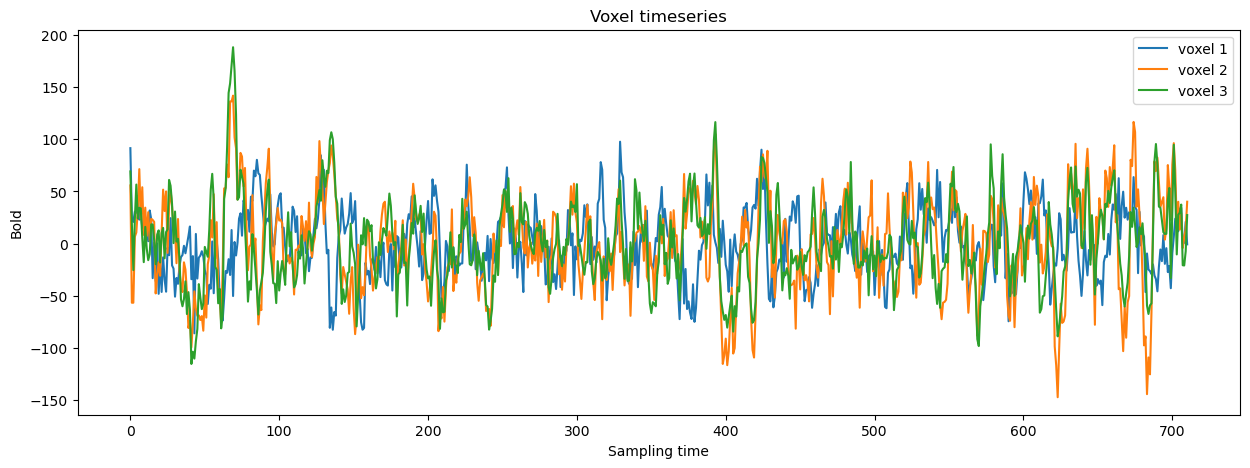

In [80]:
filename = 'TC_400_sub-S09_ses-4_Sintel.csv'
tmp      = df_to_timeseries(mri_df, filename)

plt.figure(figsize=(15,5))
plt.plot(tmp[:,0], label='voxel 1')
plt.plot(tmp[:,10], label='voxel 2')
plt.plot(tmp[:,20], label='voxel 3')
plt.legend()
plt.title('Voxel timeseries')
plt.xlabel('Sampling time')
plt.ylabel('Bold')

Combine Subcortical and Cortical

In [11]:
mri_df = pd.read_csv('./data/fmri400_compiled/AfterTheRain_compiled.csv')

In [19]:
with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

In [54]:
subcort = mri_df[mri_df.parcel == 14]
tmp_df  = mri_df.drop(subcort.index)

subcort['full_region'] = np.array(text)[np.array(subcort.vindex)]
subcort['vindex'] = 400 + subcort['vindex'] 
subcort['partial_region'] = 'Sub'

res_df = pd.concat([tmp_df,subcort])

/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_77068/1673759976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subcort['full_region'] = np.array(text)[np.array(subcort.vindex)]
/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_77068/1673759976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subcort['vindex'] = 400 + subcort['vindex']
/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_77068/1673759976.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy o